<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Some-general-parameters" data-toc-modified-id="Some-general-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some general parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overlap-representations" data-toc-modified-id="Overlap-representations-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Overlap representations</a></span></li><li><span><a href="#Calculate-total-success" data-toc-modified-id="Calculate-total-success-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Calculate total success</a></span></li><li><span><a href="#Calculate-total-success-with-trials" data-toc-modified-id="Calculate-total-success-with-trials-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>Calculate total success with trials</a></span></li><li><span><a href="#Calculate-disambiguation-success" data-toc-modified-id="Calculate-disambiguation-success-1.2.0.4"><span class="toc-item-num">1.2.0.4&nbsp;&nbsp;</span>Calculate disambiguation success</a></span></li><li><span><a href="#Calculate-sigma-sweep" data-toc-modified-id="Calculate-sigma-sweep-1.2.0.5"><span class="toc-item-num">1.2.0.5&nbsp;&nbsp;</span>Calculate sigma sweep</a></span></li><li><span><a href="#Plot-mean-success-vs-sigma" data-toc-modified-id="Plot-mean-success-vs-sigma-1.2.0.6"><span class="toc-item-num">1.2.0.6&nbsp;&nbsp;</span>Plot mean success vs sigma</a></span></li><li><span><a href="#Plot-mean-persistent-time-vs-sigma" data-toc-modified-id="Plot-mean-persistent-time-vs-sigma-1.2.0.7"><span class="toc-item-num">1.2.0.7&nbsp;&nbsp;</span>Plot mean persistent time vs sigma</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Disambiguation" data-toc-modified-id="Disambiguation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Disambiguation</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Noise-profile" data-toc-modified-id="Noise-profile-2.1.0.1"><span class="toc-item-num">2.1.0.1&nbsp;&nbsp;</span>Noise profile</a></span></li><li><span><a href="#Profile-vs-sequence-length" data-toc-modified-id="Profile-vs-sequence-length-2.1.0.2"><span class="toc-item-num">2.1.0.2&nbsp;&nbsp;</span>Profile vs sequence length</a></span></li></ul></li></ul></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Systematic</a></span><ul class="toc-item"><li><span><a href="#Fix-tau_z" data-toc-modified-id="Fix-tau_z-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Fix tau_z</a></span></li><li><span><a href="#Fix-noise" data-toc-modified-id="Fix-noise-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Fix noise</a></span></li><li><span><a href="#max-sequence-disambiguation" data-toc-modified-id="max-sequence-disambiguation-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>max sequence disambiguation</a></span></li></ul></li></ul></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Some general parameters

In [2]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 3.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

#### Overlap representations

In [3]:
from copy import deepcopy

def create_overalaped_representation(manager, representation_overlap, sequence_overlap):
    x = deepcopy(manager.canonical_activity_representation)

    to_modify = int(representation_overlap * len(x[0]))
    sequence_size = int(0.5 * len(x))
    sequence_overlap_size = int(sequence_overlap * sequence_size)
    start_point = int(0.5 * sequence_size + sequence_size - np.floor(sequence_overlap_size/ 2.0))
    end_point = start_point + sequence_overlap_size

    for sequence_index in range(start_point, end_point):
        pattern = x[sequence_index]
        pattern[:to_modify] = manager.canonical_activity_representation[sequence_index - sequence_size][:to_modify]

    return x

#### Calculate total success

In [4]:
def calculate_total_success(manager, representation, patterns_per_sequence, T_persistence=0.050,
                            remove=remove, n_cues=2, verbose=False):
    
    T_cue = 2.0 * manager.nn.tau_s
    T_recall = n_cues * T_persistence * patterns_per_sequence + T_cue

    nr1 = representation.network_representation[:patterns_per_sequence]
    nr2 = representation.network_representation[patterns_per_sequence:]

    # Success 1
    aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success1, pattern_sequence1, persistent_times1, timings1 = aux1

    # Success 2
    aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success2, pattern_sequence2, persistent_times2, timings2 = aux2
    
    total_success = 0.5 * success1 + 0.5 * success2
    
    if verbose:
        print('T_recall', T_recall)
        print('s1', success1)
        print('sequence1', pattern_sequence1)
        print('persistence1', persistent_times1)
        print('s2', success2)
        print('sequence2', pattern_sequence2)
        print('persistence2', persistent_times2)
        print('remove', remove)

    return total_success

#### Calculate total success with trials

In [5]:
def calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                   T_persistence=0.100, remove=remove, n_cues=2, verbose=False):
    
    total_success_vector = np.zeros(n_samples)

    for i in range(n_samples):
        total_success_vector[i] = calculate_total_success(manager, representation, 
                                                          patterns_per_sequence, T_persistence=T_persistence, 
                                                          remove=remove, n_cues=n_cues, verbose=verbose)
    
    return total_success_vector

#### Calculate disambiguation success

In [6]:
def calculate_dis_success(representation_overlap=1.0, sequence_overlap=0.5, minicolumns=20, 
                          hypercolumns=10, tt=0.100, ipi=0, tau_z_pre=0.025, tau_z_post=0.005, 
                          sigma_out=0.0, T_persistence=0.100, n_samples=1, n_cues=1.0,
                          remove=remove, verbose=False):
    
    strict_maximum = True

    g_a = 1.0
    g_I = 2.0
    tau_a = 0.250
    G = 1.0
    sigma_out = sigma_out
    tau_s = 0.010
    tau_z_pre = tau_z_pre
    tau_z_post = tau_z_post

    hypercolumns = hypercolumns
    minicolumns = minicolumns
    n_patterns = minicolumns
    patterns_per_sequence = int(n_patterns / 2)
    representation_overlap = representation_overlap
    sequence_overlap = sequence_overlap
    if verbose:
        print('patterns per sequence', patterns_per_sequence)
        print('(p, q)', representation_overlap, sequence_overlap)
    
    # Training protocol
    training_times_base = tt
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = ipi
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 1.0
    resting_time = 1.0
    epochs = 1

    # Manager properties
    values_to_save = ['o']


    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the representation
    activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
    representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
    inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval
    if verbose:
        print(activity_representation)
    
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, 
                             inter_pulse_intervals=inter_pulse_intervals, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    # Set the persistent time
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    # Calculate total success
    total_success_vector = calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                                         T_persistence=T_persistence, remove=remove, 
                                                         n_cues=n_cues, verbose=verbose)
    
    return total_success_vector, manager

#### Calculate sigma sweep

In [7]:
def run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, patterns_per_sequence,
                    T_persistence=0.100, remove=remove, n_cues=1):
    
    sigma_vector = np.linspace(0, sigma_max, num=sigma_number)
    successes_collection = np.zeros((sigma_number, n_samples))

    for index, sigma in enumerate(sigma_vector):
        manager.nn.sigma_out = sigma
        manager.nn.sigma_in = sigma * np.sqrt(2 / manager.nn.tau_s)
        aux = calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                            T_persistence=0.100, remove=remove, n_cues=n_cues)
        
        successes_collection[index, :] = aux
        
    results_dic = {'manager': manager, 'sigma_vector': sigma_vector, 'success': successes_collection}

    return results_dic

#### Plot mean success vs sigma

In [8]:
def plot_mean_success_vs_sigma(results_dictionary, n_samples, index=0, label=0, ax=None, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')

    # Plot the mean
    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms, color=colors[index], label=label)
    
    if False:
        # Plot sigma05
        sigma09_arg = np.where(mean_success <= 0.9)[0]
        if sigma09_arg.size > 0:
            sigma09 = sigma_vector[sigma09_arg[0]]
            ax.plot(sigma09, 0.9, '*', ms=(ms + 20), color='black')

        sigma01_arg = np.where(mean_success <= 0.1)[0]
        if sigma01_arg.size > 0:
            sigma01 = sigma_vector[sigma01_arg[0]]
            ax.plot(sigma01, 0.1, '*', ms=(ms + 20), color='black')
    
    # Plot the interval
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)
    
    if add_zero_axis:
        ax.axhline(0, ls='--', color='gray')
        ax.axvline(0, ls='--', color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success rate')
    ax.legend(frameon=False)

    return ax

#### Plot mean persistent time vs sigma

In [9]:
def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    low = np.zeros(sigma_vector.size)
    high = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)
        low[sigma_index] = np.percentile(flatted, 25)
        high[sigma_index] = np.percentile(flatted, 75)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    ax.fill_between(sigma_vector, low, high,color=colors[index], alpha=alpha_graph)
    if add_zero_axis:
        ax.axhline(0, ls='--',color='gray')
        ax.axvline(0, ls='--',color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence} (s)$')

    if single:
        ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )
        ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
        ax.legend(frameon=False)
    
    return ax

# Disambiguation

## An example

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [ 6]
 [17]
 [18]
 [19]]
CPU times: user 184 ms, sys: 12 ms, total: 196 ms
Wall time: 114 ms


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


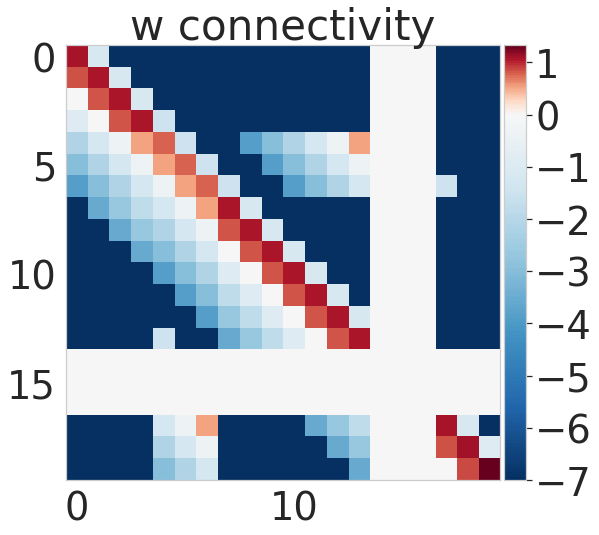

In [10]:
%%time 
sigma_out = 0.2
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

print(activity_representation)

    
# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
plot_weight_matrix(manager)

1.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 5, 6, 17, 18]
[0.036000000000000004, 0.024, 0.016, 0.01, 0.025, 0.029, 0.039, 0.036000000000000004, 0.018000000000000002, 0.034, 0.032, 0.032, 0.013000000000000001, 0.023, 0.011, 0.034, 0.045, 0.028, 0.02, 0.044, 0.046, 0.033, 0.037, 0.011]


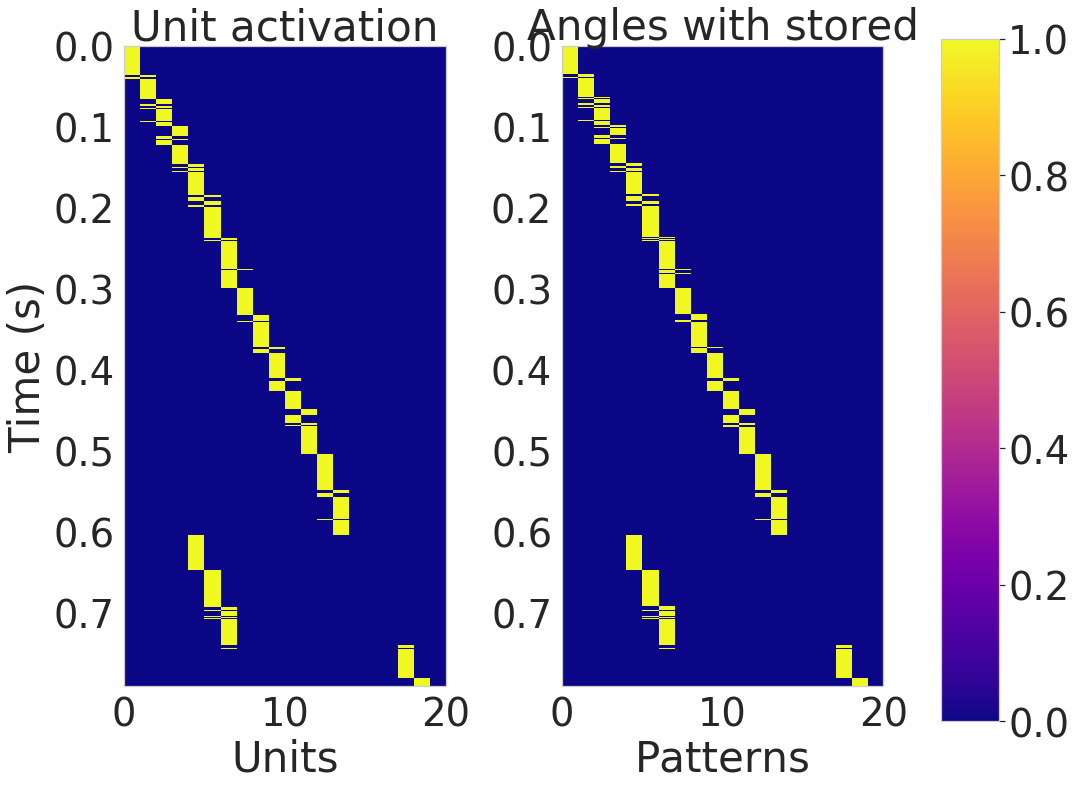

In [11]:
T_cue = 2 * manager.nn.tau_s
T_recall = 3 * T_persistence * patterns_per_sequence + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
print(success1)
print(pattern_sequence1)
print(persistent_times1)

plot_network_activity_angle(manager, time_y=True);

0.0
[10, 11, 12, 13, 4, 5, 6, 17, 18, 17, 18, 19, 18, 19, 18]
[0.041, 0.043000000000000003, 0.027, 0.033, 0.02, 0.031, 0.012, 0.051000000000000004, 0.033, 0.012, 0.01, 0.024, 0.155, 0.019, 0.032, 0.014, 0.025, 0.03, 0.061, 0.03, 0.016]


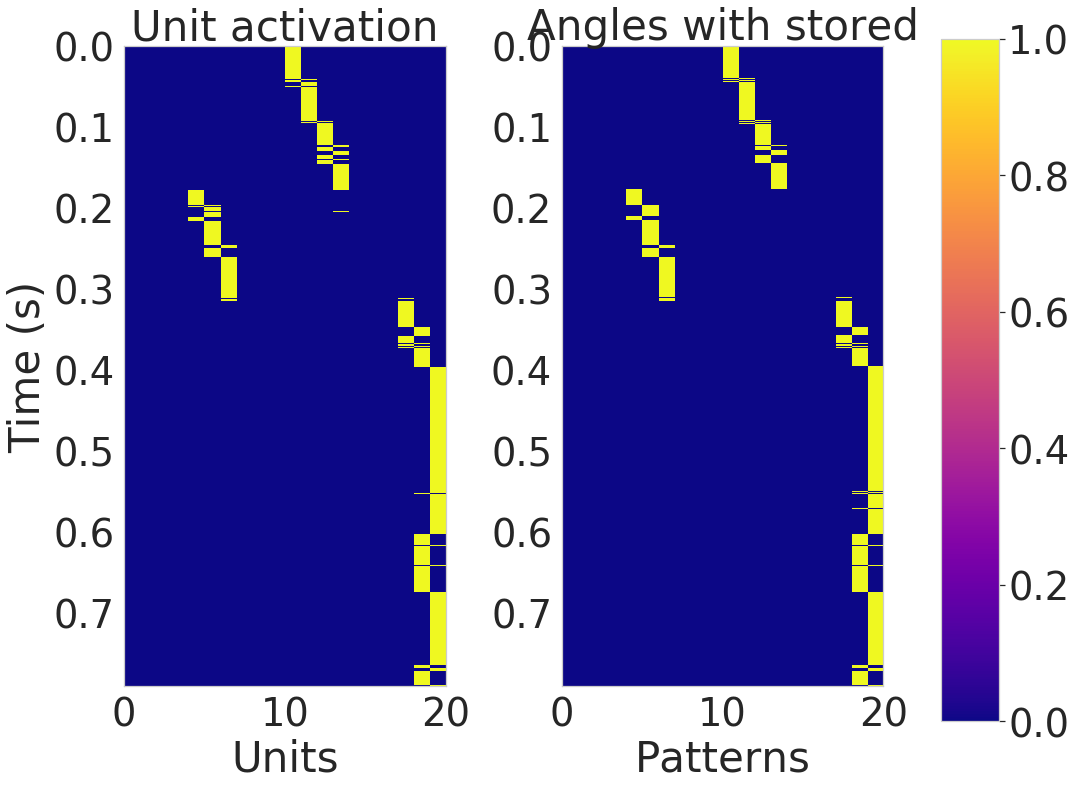

In [12]:
# Success 2
aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success2, pattern_sequence2, persistent_times2, timings2 = aux2
print(success2)
print(pattern_sequence2)
print(persistent_times2)

plot_network_activity_angle(manager, time_y=True);

#### Noise profile

In [13]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.2
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

print(activity_representation)

    
# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)

sigma_number = 20
n_samples = 20
sigma_max = 1.0

results_dic = run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, 
                              patterns_per_sequence, T_persistence=T_persistence, remove=remove, n_cues=2)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [16]
 [17]
 [18]
 [19]]


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


CPU times: user 5min 8s, sys: 88 ms, total: 5min 8s
Wall time: 5min 7s


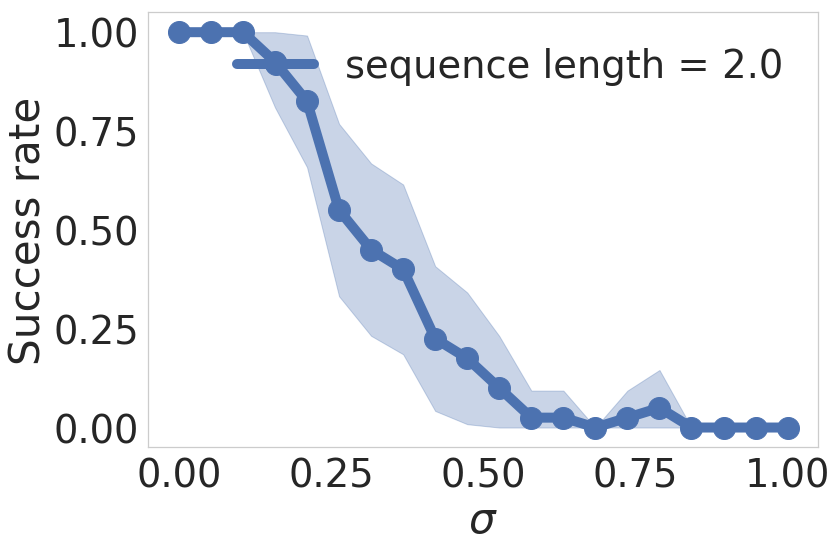

In [14]:
index = 0
ax = None
label = r'sequence length = ' + str(sequence_overlap * 10)
results_dictionary = results_dic
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, label=label, ax=ax)

#### Profile vs sequence length

In [15]:
%%time
aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                            hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=0.050, tau_z_post=0.005,  
                            sigma_out=sigma_out, T_persistence=0.025, n_samples=1, n_cues=3.0, 
                            remove=remove, verbose=True)

success, manager = aux

patterns per sequence 10
(p, q) 1.0 0.2
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [16]
 [17]
 [18]
 [19]]


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


T_recall 0.7700000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.036000000000000004, 0.042, 0.042, 0.01, 0.033, 0.043000000000000003, 0.053, 0.049, 0.042, 0.041, 0.17200000000000001, 0.057, 0.10400000000000001, 0.014, 0.027]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.037, 0.038, 0.043000000000000003, 0.039, 0.054, 0.059000000000000004, 0.036000000000000004, 0.038, 0.048, 0.195, 0.049, 0.098, 0.041]
remove 0.01
CPU times: user 1.11 s, sys: 80 ms, total: 1.19 s
Wall time: 508 ms


In [16]:
%%time
sequence_overlaps = np.linspace(0.1, 0.8, 8)
success_vector = np.zeros(sequence_overlaps.size)
n_samples = 25

for index, sequence_overlap in enumerate(sequence_overlaps):
    print(sequence_overlap)
    aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=0.050, tau_z_post=0.005,  
                                sigma_out=sigma_out, T_persistence=0.025, n_samples=10, n_cues=5.0, 
                                remove=remove, verbose=False)

    success, manager = aux
    success_vector[index] = np.mean(success)

0.1


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
CPU times: user 38.5 s, sys: 360 ms, total: 38.9 s
Wall time: 33.6 s


(0, 1.1)

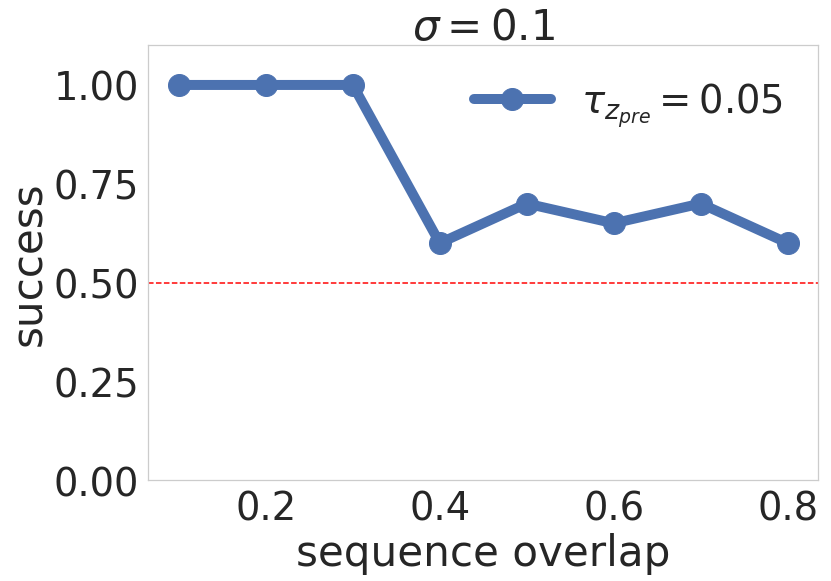

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
label = r'$\tau_{z_{pre}} = $' + str(tau_z_pre)
ax.plot(sequence_overlaps, success_vector, 'o-', ms=ms, lw=lw, label=label)

ax.set_xlabel('sequence overlap')
ax.set_ylabel('success')
ax.set_title(r'$\sigma = $' + str(sigma_out))
ax.legend(frameon=False)

ax.axhline(0.5, ls='--', color='red')
ax.set_ylim([0, 1.1])

## Systematic

### Fix tau_z

In [18]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

sequence_overlaps = [1, 3, 5, 7]
sigma_number = 20
n_samples = 50
sigma_max = 1.0
results_dictionary_collection_fix_tau_z = {}

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

for index, sequence_overlap in enumerate(sequence_overlaps):
    print(sequence_overlap)
    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)


    # Build the representation
    representation_overlap = 1.0
    patterns_per_sequence = 10
    activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap/10.0)
    representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
    inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    # Set the persistent time
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)



    results_dic = run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, 
                                  patterns_per_sequence, T_persistence=T_persistence, remove=remove, n_cues=2)
    
    results_dictionary_collection_fix_tau_z[sequence_overlap] = results_dic

1


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


3
5
7
CPU times: user 52min 3s, sys: 344 ms, total: 52min 3s
Wall time: 52min 2s


Text(0.5, 1.0, '$\\tau_{z_{pre}} = $0.05')

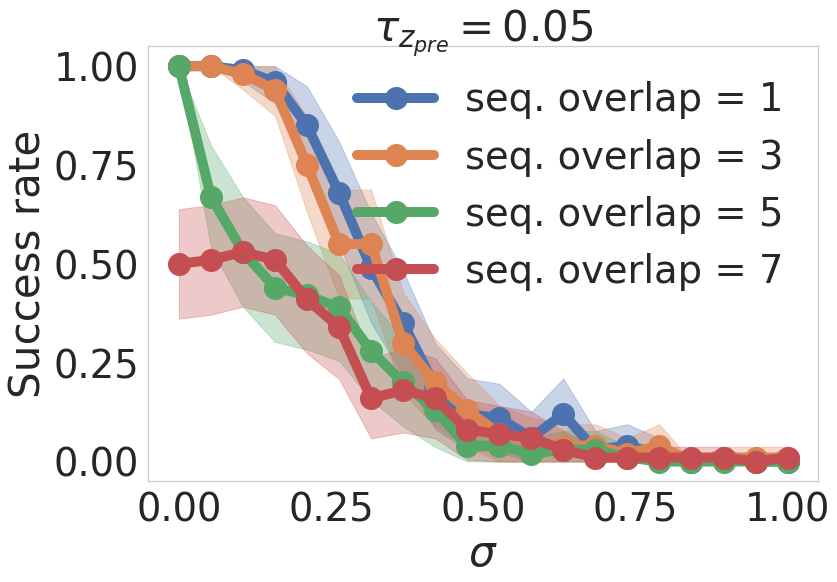

In [20]:
index = 0
ax = None
for index, sequence_overlap in enumerate(sequence_overlaps):
    label = r'seq. overlap = ' + str(sequence_overlap)
    results_dictionary = results_dictionary_collection_fix_tau_z[sequence_overlap]
    ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, label=label, ax=ax)

ax.set_title(r'$\tau_{z_{pre}} = $' + str(tau_z_pre))

In [23]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

sequence_overlaps = [2, 4, 6]
sigma_number = 20
n_samples = 500
sigma_max = 1.0
results_dictionary_collection_fix_tau_z = {}

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

for index, sequence_overlap in enumerate(sequence_overlaps):
    print(sequence_overlap)
    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)


    # Build the representation
    representation_overlap = 1.0
    patterns_per_sequence = 10
    activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap/10.0)
    representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
    inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    # Set the persistent time
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)



    results_dic = run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, 
                                  patterns_per_sequence, T_persistence=T_persistence, remove=remove, n_cues=2)
    
    results_dictionary_collection_fix_tau_z[sequence_overlap] = results_dic

2


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


4
6
CPU times: user 6h 27min 56s, sys: 1.85 s, total: 6h 27min 58s
Wall time: 6h 28min 2s


Text(0.5, 1.0, '$\\tau_{z_{pre}} = $50.0 ms')

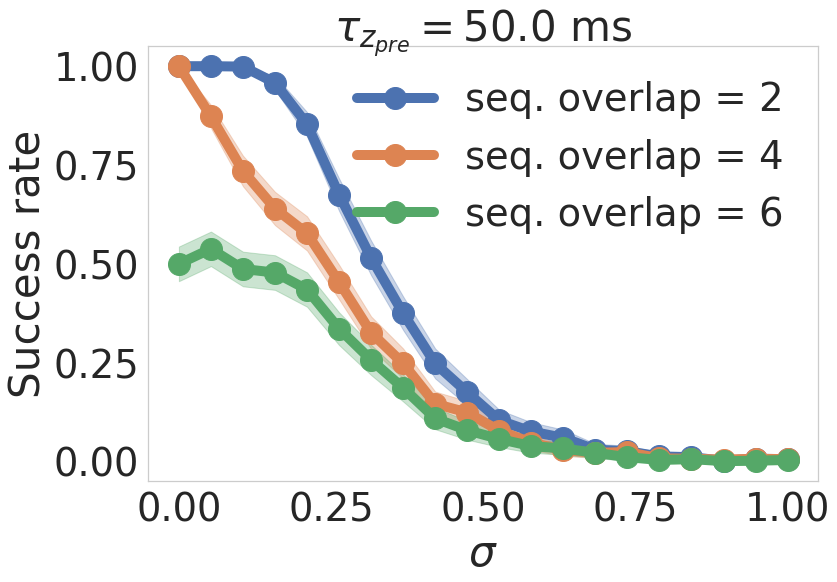

In [24]:
index = 0
ax = None
for index, sequence_overlap in enumerate(sequence_overlaps):
    label = r'seq. overlap = ' + str(sequence_overlap)
    results_dictionary = results_dictionary_collection_fix_tau_z[sequence_overlap]
    ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, label=label, ax=ax)

ax.set_title(r'$\tau_{z_{pre}} = $' + str(tau_z_pre * 1000) + ' ms')

### Fix noise

In [25]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

tau_z_pre_set = [0.025, 0.050, 0.075, 0.100]
sequence_overlaps = np.linspace(0.1, 0.8, 8)
n_samples = 50
success_list = []

for tau_z_pre in tau_z_pre_set:
    print(tau_z_pre)
    success_vector = np.zeros(sequence_overlaps.size)

    for index, sequence_overlap in enumerate(sequence_overlaps):
        aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                    hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,  
                                    sigma_out=sigma_out, T_persistence=T_persistence, n_samples=n_samples, n_cues=5.0, 
                                    remove=remove, verbose=False)

        success, manager = aux
        success_vector[index] = np.mean(success)
        
    success_list.append(success_vector)

0.025


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


0.05
0.075
0.1
CPU times: user 11min 22s, sys: 1.37 s, total: 11min 23s
Wall time: 11min 3s


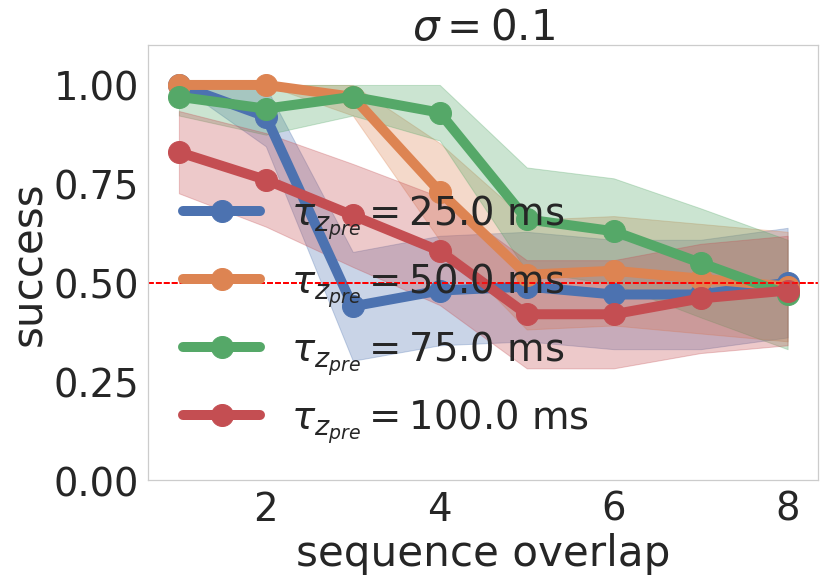

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}} = $' + str(tau_z_pre * 1000) + ' ms'
    ax.plot(sequence_overlaps * 10, success_list[index], 'o-', ms=ms, lw=lw, label=label)
    # INTERVAL
    ci_low, ci_upp = sm.stats.proportion_confint(success_list[index] * n_samples, n_samples, alpha=0.05, method='normal')
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sequence_overlaps * 10, low, high, color=colors[index], alpha=alpha_graph)
    # 
    ax.set_xlabel('sequence overlap')
    ax.set_ylabel('success')
    ax.set_title(r'$\sigma = $' + str(sigma_out))
    ax.legend(frameon=False)

    ax.axhline(0.5, ls='--', color='red')
    ax.set_ylim([0, 1.1])

In [27]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

tau_z_pre_set = [0.030, 0.060, 0.090]
sequence_overlaps = np.linspace(0.1, 0.8, 8)
n_samples = 500
success_list = []

for tau_z_pre in tau_z_pre_set:
    print(tau_z_pre)
    success_vector = np.zeros(sequence_overlaps.size)

    for index, sequence_overlap in enumerate(sequence_overlaps):
        aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                    hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,  
                                    sigma_out=sigma_out, T_persistence=T_persistence, n_samples=n_samples, n_cues=5.0, 
                                    remove=remove, verbose=False)

        success, manager = aux
        success_vector[index] = np.mean(success)
        
    success_list.append(success_vector)

0.03


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


0.06
0.09
CPU times: user 1h 22min 8s, sys: 1.59 s, total: 1h 22min 9s
Wall time: 1h 21min 54s


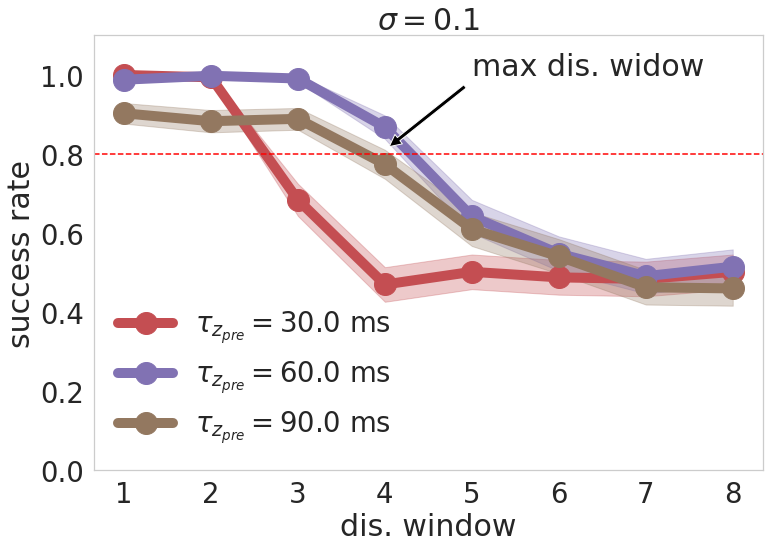

In [28]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure()
ax = fig.add_subplot(111)

for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}} = $' + str(tau_z_pre * 1000) + ' ms'
    ax.plot(sequence_overlaps * 10, success_list[index], 'o-', color=colors[index + 3], ms=ms, lw=lw, label=label)
    # INTERVAL
    ci_low, ci_upp = sm.stats.proportion_confint(success_list[index] * n_samples, n_samples, alpha=0.05, method='normal')
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sequence_overlaps * 10, low, high, color=colors[index + 3], alpha=alpha_graph)
     
ax.set_xlabel('dis. window')
ax.set_ylabel('success rate')
ax.set_title(r'$\sigma = $' + str(sigma_out))
ax.legend(frameon=False, loc='lower left')

ax.axhline(0.8, ls='--', color='red')
ax.set_ylim([0, 1.1])
ax.annotate('max dis. widow', xy=(4, 0.81), xytext=(5, 1.0),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
directory = '../plot_producers/'
file_name = 'noise2' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

### max sequence disambiguation

In [ ]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

sys_number = 25
sigma_out_set = [0.05, 0.1, 0.15]
n_samples = 500
tolerance = 0.8
tau_z_pre_set_sys = np.linspace(0.025, 0.100, num=sys_number)
sequence_overlaps = np.linspace(0.1, 0.8, 8)
max_seq_array = np.zeros((sys_number, len(sigma_out_set)))

verbose = True

for tau_index, tau_z_pre in enumerate(tau_z_pre_set_sys):
    print('tau_z_pre', tau_z_pre)
    for sigma_index, sigma_out in enumerate(sigma_out_set):
        if verbose:
            print('sigma out', sigma_out)
        for index, sequence_overlap in enumerate(sequence_overlaps):
            if verbose:
                print('seq. overlap', sequence_overlap)
            aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                        hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,  
                                        sigma_out=sigma_out, T_persistence=T_persistence, n_samples=n_samples, n_cues=5.0, 
                                        remove=remove, verbose=False)

            success, manager = aux
            if verbose:
                print('success', np.mean(success))
            if np.mean(success) < tolerance:
                
                max_seq_array[tau_index, sigma_index] = sequence_overlap*10.0 - 1.0
                if verbose:
                    print('Broke')
                    print('******')
                break
    if verbose:
        print('----------')
    success_list.append(success_vector)

tau_z_pre 0.025
sigma out 0.05
seq. overlap 0.1


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


success 1.0
seq. overlap 0.2
success 0.999
seq. overlap 0.30000000000000004
success 0.483
Broke
******
sigma out 0.1
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 0.952
seq. overlap 0.30000000000000004
success 0.468
Broke
******
sigma out 0.15
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 0.864
seq. overlap 0.30000000000000004
success 0.492
Broke
******
----------
tau_z_pre 0.028125
sigma out 0.05
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 1.0
seq. overlap 0.30000000000000004
success 0.782
Broke
******
sigma out 0.1
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 0.989
seq. overlap 0.30000000000000004
success 0.647
Broke
******
sigma out 0.15
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 0.952
seq. overlap 0.30000000000000004
success 0.611
Broke
******
----------
tau_z_pre 0.03125
sigma out 0.05
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 1.0
seq. overlap 0.30000000000000004
success 0.846
seq. overlap 0.4
success 0.49
Broke
******
sigm

In [ ]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure()
ax = fig.add_subplot(111)

for index, max_seq in enumerate(max_seq_array.T):
    label = r'$\sigma = $' + str(sigma_out_set[index])
    ax.plot(tau_z_pre_set_sys * 1000.0, max_seq, 'o-', ms=ms, lw=lw, label=label)
    
ax.set_xlabel(r'$\tau_{z_{pre}}$ (ms)')
ax.set_ylabel('max disambiguation win.')
ax.set_title(r'success rate > 80 %' )

ax.set_ylim([-0.25, 6])

if False:
    ax.axhline(0, ls='--', color='gray')
    ax.axhline(1, ls='--', color='gray')
    ax.axhline(2, ls='--', color='gray')
    ax.axhline(3, ls='--', color='gray')
    ax.axhline(4, ls='--', color='gray')
    ax.axhline(5, ls='--', color='gray')
else:
    ax.grid()
    
ax.legend(frameon=False, loc=(-0.001, 0.875), ncol=3)

directory = '../plot_producers/'
file_name = 'noise' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)